In [1]:
!tree -h ../data/enwiki

../data/enwiki
├── [ 256]  categorylinks
│   ├── [   0]  _SUCCESS
│   ├── [222M]  part-00000-5c4ff747-a7d2-48b6-8e21-e82a4b8840dd-c000.snappy.parquet
│   └── [233M]  part-00001-5c4ff747-a7d2-48b6-8e21-e82a4b8840dd-c000.snappy.parquet
├── [ 192]  categorypages
│   ├── [   0]  _SUCCESS
│   └── [ 32M]  part-00000-e856fb1e-f22c-4c36-9ed1-5621bab499a9-c000.snappy.parquet
├── [ 384]  page_parquet
│   ├── [   0]  _SUCCESS
│   ├── [179M]  part-00000-e97ee0ca-9896-4efe-88a7-8cf2080e6443-c000.snappy.parquet
│   ├── [175M]  part-00001-e97ee0ca-9896-4efe-88a7-8cf2080e6443-c000.snappy.parquet
│   ├── [181M]  part-00002-e97ee0ca-9896-4efe-88a7-8cf2080e6443-c000.snappy.parquet
│   └── [182M]  part-00003-e97ee0ca-9896-4efe-88a7-8cf2080e6443-c000.snappy.parquet
├── [ 192]  pagecount_daily_v1
│   ├── [   0]  _SUCCESS
│   └── [ 63M]  part-00000-403e555c-eed5-4476-8908-b019dfcd08d4-c000.snappy.parquet
├── [ 256]  pagecount_daily_v2
│   ├── [   0]  _SUCCESS
│   ├── [235M]  part-00000-97cd53e2-dab7-4dc1-bb1

In [2]:
base = "../data/enwiki"
pages = spark.read.parquet(f"{base}/pages")
pagelinks = spark.read.parquet(f"{base}/pagelinks")
categorypages = spark.read.parquet(f"{base}/categorypages")
categorylinks = spark.read.parquet(f"{base}/categorylinks")

pages.createOrReplaceTempView("pages")
pagelinks.createOrReplaceTempView("pagelinks")
categorypages.createOrReplaceTempView("categorypages")
categorylinks.createOrReplaceTempView("categorylinks")

In [12]:
pages.show(truncate=False, n=10)
pagelinks.show(n=10)
categorypages.show(truncate=False, n=10)
categorylinks.show(n=10)

+---+----------------------------------------+-----------+------+
|id |title                                   |is_redirect|is_new|
+---+----------------------------------------+-----------+------+
|12 |Anarchism                               |false      |false |
|25 |Autism                                  |false      |false |
|39 |Albedo                                  |false      |false |
|290|A                                       |false      |false |
|303|Alabama                                 |false      |false |
|305|Achilles                                |false      |false |
|307|Abraham_Lincoln                         |false      |false |
|308|Aristotle                               |false      |false |
|309|An_American_in_Paris                    |false      |false |
|316|Academy_Award_for_Best_Production_Design|false      |false |
+---+----------------------------------------+-----------+------+
only showing top 10 rows

+--------+--------+
|    from|    dest|
+--------+

In [4]:
from graphframes import GraphFrame
from pyspark.sql import functions as F

g_page = GraphFrame(pages, pagelinks.selectExpr("from as src", "dest as dst"))
g_cat = GraphFrame(categorypages, categorylinks.selectExpr("from as src", "dest as dst"))

In [5]:
import matplotlib.pyplot as plt

def plot_degree(df):
    df = df.toPandas()
    ax = df.plot.scatter(x="degree", y="freq", loglog=True)
    ax.set_xlim(df.min().degree, df.max().degree)
    ax.set_ylim(df.min()["freq"], df.max()["freq"])
    plt.show()
    
plot_degree(
    g_page.inDegrees.groupBy("inDegree").count()
    .selectExpr("inDegree as degree", "count as freq")
)

plot_degree(
    g_cat.inDegrees.groupBy("inDegree").count()
    .selectExpr("inDegree as degree", "count as freq")
)

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

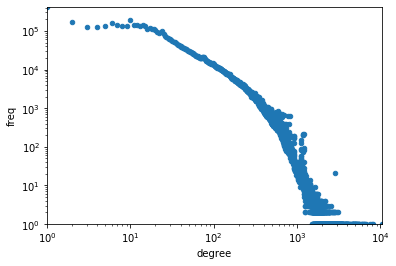

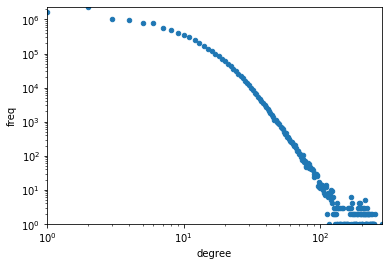

In [6]:
plot_degree(
    g_page.outDegrees.groupBy("outDegree").count()
    .selectExpr("outDegree as degree", "count as freq")
)

plot_degree(
    g_cat.outDegrees.groupBy("outDegree").count()
    .selectExpr("outDegree as degree", "count as freq")
)

In [29]:
def sample_page() -> int:
    random_page = pages.sample(False, 0.001).limit(1).collect()[0]
    return random_page.id

seed = sample_page()
pages.where(f"id = {seed}").show()

v = g_page.find("""
(a)-[]->(b);
(b)-[]->(c)
""").where(f"b.id = {seed}")

v_set = v.selectExpr("a as v").union(v.selectExpr("b as v")).union(v.selectExpr("c as v")).distinct().select("v.*")
v.cache()
v.count()

+----+---------------+-----------+------+
|  id|          title|is_redirect|is_new|
+----+---------------+-----------+------+
|2241|Antonio_Salieri|      false| false|
+----+---------------+-----------+------+

+--------------------+
|                   v|
+--------------------+
|[7561507, Ramón_V...|
|[23865486, Alessa...|
|[11246, Falstaff,...|
|[477170, Matthew_...|
|[234507, The_New_...|
|[29697232, NPR, f...|
|[24449007, Zehava...|
|[15260106, Mozart...|
|[34350, Yoko_Ono,...|
|[19397243, Sympho...|
|[38402833, Music_...|
|[44240, Catherine...|
|[842288, Alessand...|
|[19397470, Sympho...|
|[249524, Harrowin...|
|[38846595, Mass_N...|
|[283846, Culture_...|
|[18181788, Wiener...|
|[11895304, Bampto...|
|[4520713, Piano_C...|
+--------------------+
only showing top 20 rows



852

In [47]:
v = v_set.select("v.*")

In [115]:
filtered = (
    pagelinks
    .join(v, on=pagelinks["from"]==v["id"], how="right")
    .select("from", "dest")
    .join(v, on=pagelinks["dest"]==v["id"], how="right")
    .select("from", "dest")
    .where("from is not null AND dest is not null")
)

filtered.count()

33885

In [116]:
g_sub = GraphFrame(v, filtered.selectExpr("from as src", "dest as dst"))

In [117]:
g_sub.vertices.count(), g_sub.edges.count()

(852, 33885)

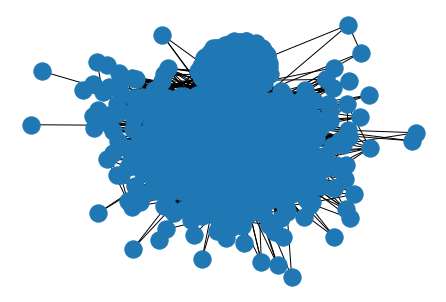

In [118]:
import networkx as nx
import matplotlib.pyplot as plt

g_sub_nx = nx.from_pandas_edgelist(g_sub.edges.toPandas(), source="src", target="dst")
nx.draw(g_sub_nx)

/Users/amiyaguchi/.local/share/virtualenvs/wiki-forecast-HU65IRGn/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


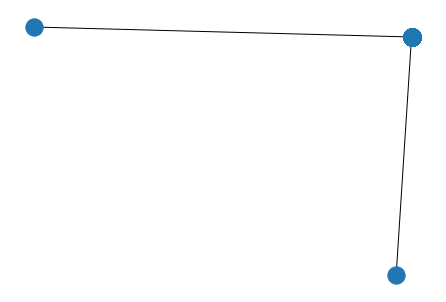

In [119]:
nx.draw_spectral(g_sub_nx, edge_width=0.2)

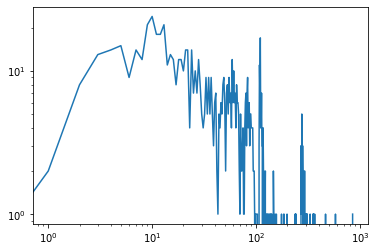

In [121]:
from matplotlib import pyplot as plt

plt.loglog(*list(zip(*list(enumerate(nx.degree_histogram(g_sub_nx))))))

In [122]:
nx.average_clustering(g_sub_nx)

0.6098831853657385

In [123]:
nx.density(g_sub_nx)

0.07529115153120051

In [124]:
print(nx.info(g_sub_nx))

Name: 
Type: Graph
Number of nodes: 852
Number of edges: 27295
Average degree:  64.0728


In [60]:
spark.sparkContext.setCheckpointDir('/tmp/checkpoints')

In [98]:
g_sub.connectedComponents().groupBy("component").count().show()

+---------+-----+
|component|count|
+---------+-----+
|      324|  852|
+---------+-----+



In [99]:
g_sub.vertices.show(n=3)

+--------+--------------------+-----------+------+
|      id|               title|is_redirect|is_new|
+--------+--------------------+-----------+------+
| 7561507|        Ramón_Vargas|      false| false|
|23865486|Alessandro_Carbonare|      false| false|
|   11246|            Falstaff|      false| false|
+--------+--------------------+-----------+------+
only showing top 3 rows



In [100]:
g_sub.vertices.where("id is null").count()

0

In [109]:
g_sub.vertices.printSchema()
g_page.vertices.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- is_redirect: boolean (nullable = true)
 |-- is_new: boolean (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- is_redirect: boolean (nullable = true)
 |-- is_new: boolean (nullable = true)



In [114]:
g_sub.edges.where("from is null or dest is null").count()

75

In [ ]:
pr = g_sub.pageRank(resetProbability=0.15, tol=0.01)
pr.cache()

In [131]:
pr.vertices.orderBy(F.desc("pagerank")).select("id", "title", "pagerank").show(truncate=False)
pr.vertices.orderBy(F.asc("pagerank")).select("id", "title", "pagerank").show(truncate=False)
pr.edges.show()

+--------+--------------------------------------+------------------+
|id      |title                                 |pagerank          |
+--------+--------------------------------------+------------------+
|25175562|Virtual_International_Authority_File  |36.978157384342104|
|14919   |International_Standard_Book_Number    |31.7986134422773  |
|35566739|Integrated_Authority_File             |30.35888147336831 |
|23538754|Wayback_Machine                       |24.239472340615595|
|1339871 |WorldCat                              |22.418537446144683|
|1491462 |Library_of_Congress_Control_Number    |20.700324413268596|
|18852926|International_Standard_Name_Identifier|19.014520884338374|
|199503  |Bibliothèque_nationale_de_France      |18.502838145691662|
|3198808 |Biblioteca_Nacional_de_España         |16.77436340353904 |
|883885  |OCLC                                  |15.419326027180198|
|5418449 |LIBRIS                                |12.914466171281532|
|20012045|National_Library_of_the_